In [2]:
import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


xgboost 比较好用

XGboost本身的核心是基于梯度提升树实现的集成算法，整体来说可以有三部分核心过程，集成算法、弱评估器、其他过程。

集成算法有装袋法（bagging）和提升法（boosting）两种，其中装代法中以随机森林为代表，提升法中以Adaboost和梯度提升树   
为代表，XGboost就是由梯度提升树发展来的，梯度提升树有分类树和回归树，两者都是以CART算法作为主流。

梯度提升回归树：   
对决策树而言，每个被放入模型的样本最终都会落到一个叶子节点上。对于回归树，每个叶子节点上的值是这个叶子节点上所有样本的均值。   
对于梯度提升树来说，每个样本的预测结果可以表示为所有树上的结果的加权求和。   
XGB和GBDT的y预测值却不相同。  
XGB来说，每个叶子节点上会有一个预测分数，被称为叶子权重。这个叶子权重就是所有在这个叶子节点上的样本在这一颗树上的回归取值。   
对于GBDT，预测值是所有弱分类器上的预测结果的加权求和，每个样本上的预测结果就是样本所在的叶子节点的均值。

以回归树为重点进行学习

In [1]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
data = load_boston()

In [3]:
#波士顿数据集非常简单，但它所涉及到的问题却很多
X = data.data
y = data.target

In [4]:
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)

In [5]:
reg = XGBR(n_estimators=100).fit(Xtrain,Ytrain)

In [6]:
reg.predict(Xtest) #传统接口predict

array([ 6.6689262, 22.34918  , 31.052807 , 13.911593 ,  9.467967 ,
       22.658588 , 14.514282 , 15.092699 , 15.293644 , 12.680115 ,
       24.140797 , 35.890083 , 21.573483 , 27.07066  , 19.052658 ,
        9.89033  , 23.386076 , 23.588493 , 23.311466 , 22.401644 ,
       18.98444  , 15.766946 , 25.8352   , 20.193802 , 19.982517 ,
       15.611423 , 22.883228 , 29.838228 , 22.815304 , 16.779034 ,
       37.13194  , 20.133307 , 19.67352  , 23.525528 , 22.845137 ,
       23.87397  , 15.17887  , 23.45934  , 16.685331 , 31.761686 ,
       18.525843 , 22.441063 , 38.48728  , 17.93719  , 15.10122  ,
       28.980541 , 46.363487 , 12.842797 ,  9.618281 , 35.40579  ,
       25.657566 , 20.605602 , 20.800055 , 49.228447 , 31.355848 ,
       29.382515 , 18.911947 , 21.049877 , 16.165169 , 18.098577 ,
       14.659002 , 21.720213 , 19.413454 , 28.932102 , 30.573524 ,
       19.228426 , 20.531511 , 15.666288 , 23.52929  , 19.30554  ,
       28.384985 , 42.83562  , 29.429724 , 23.306015 , 19.7412

In [6]:
reg.score(Xtest,Ytest) #你能想出这里应该返回什么模型评估指标么？

0.9050988954757183

In [7]:
MSE(Ytest,reg.predict(Xtest))

8.830916470718748

In [8]:
reg.feature_importances_
#树模型的优势之一：能够查看模型的重要性分数，可以使用嵌入法SelectFromModel()进行特征选择

array([0.01902167, 0.0042109 , 0.01478317, 0.00553536, 0.02222195,
       0.37914094, 0.01679687, 0.04698721, 0.04073574, 0.05491758,
       0.0668422 , 0.00869463, 0.32011184], dtype=float32)

交叉验证在XGboost和LinearRegression和Dt模型的效果怎么样

In [9]:
reg = XGBR(n_estimators=100)  # 交叉验证需要导入的是没有经过训练的模型

In [10]:
CVS(reg,Xtrain,Ytrain,cv=5).mean()

0.799506280269948

关于交叉验证：严谨vs不严谨   
直接将全部数据放入交叉验证中，被称为不严谨的交叉验证，因为所有数据都已经被见过了。   
而严谨的交叉验证应该先将数据分为训练集和测试集，然后用训练集进行交叉验证，只有在测试集上的结果   
也比较好的时候，模型的泛华能力才算好，这称为严谨的交叉验证。

但是实际操作中有验证集和没有验证集都行，看个人选择，分开模型不一定就好。

In [11]:
#这里应该返回什么模型评估指标，还记得么？
#严谨的交叉验证与不严谨的交叉验证之间的讨论：训练集or全数据？
CVS(reg,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()
#来查看一下sklearn中所有的模型评估指标

-16.215644658473447

In [12]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [13]:
#使用随机森林和线性回归进行一个对比
rfr = RFR(n_estimators=100)

In [14]:
CVS(rfr,Xtrain,Ytrain,cv=5).mean()

0.8031186522496577

In [15]:
CVS(rfr,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

-17.27931475851107

In [16]:
lr = LinearR()
CVS(lr,Xtrain,Ytrain,cv=5).mean()

0.6835070597278081

In [17]:
CVS(lr,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

-25.34950749364843

In [18]:
#开启参数slient：在数据巨大，预料到算法运行会非常缓慢的时候可以使用这个参数来监控模型的训练进度
reg = XGBR(n_estimators=10,silent=False)

In [20]:
CVS(reg,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

[21:16:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

-18.63373361656663

由此，可以看出，随机森林&XGboost效果相差不大，LinearRegression和之相比就显得势单力薄了，没办法跟集成算法相比。

In [19]:
# 输入分类器，数据，画图所需的一系列参数，交叉验证的模式，以及其他可能的参数，一次性帮我们画出所有的学习曲线
# 找出每个图像所需的横纵坐标，绘制子图所在的画布，然后在画布上绘图
def plot_learning_curve(estimator,title, X, y,
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                        ):
    
    from sklearn.model_selection import learning_curve   # 画学习曲线的类
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 每次分训练集和测试集后训练集上的样本数量、训练集上的分数、测试集上的分数
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            # ,random_state=420
                                                            ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-' , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g",label="Test score")
    ax.legend(loc="best")
    return ax

In [20]:
cv = KFold(n_splits=5, shuffle = True  # 是否在分份前将我们的数据集打乱
           , random_state=42)   

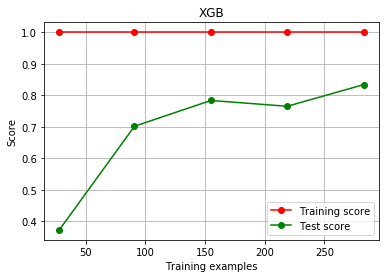

In [21]:
plot_learning_curve(XGBR(n_estimators=100,random_state=420),"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()
#多次运行，观察结果，这是怎么造成的？
#在现在的状况下，如何看数据的潜力？还能调上去么？

160 0.8320776685832459


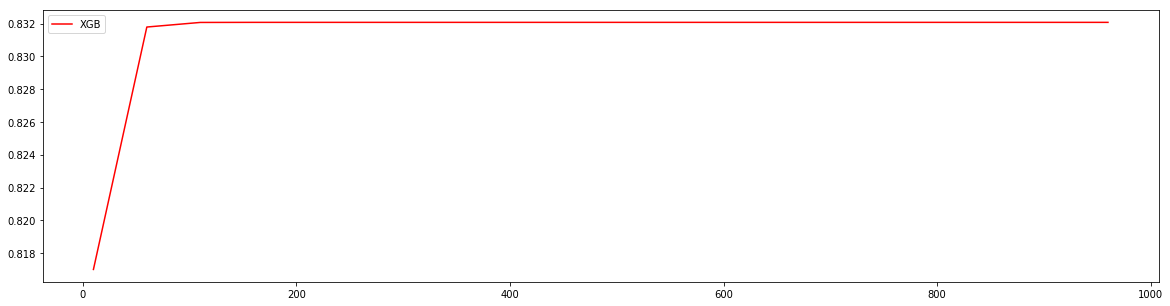

In [22]:
#==25seconds==#
axisx = range(10,1010,50)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    rs.append(CVS(reg,Xtrain,Ytrain,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()
#选出来的n_estimators非常不寻常，我们是否要选择准确率最高的n_estimators值呢？

进化的学习曲线：方差与泛华误差

泛化误差是由：偏差、方差、噪声 组成的

100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517 0.03353715574288529


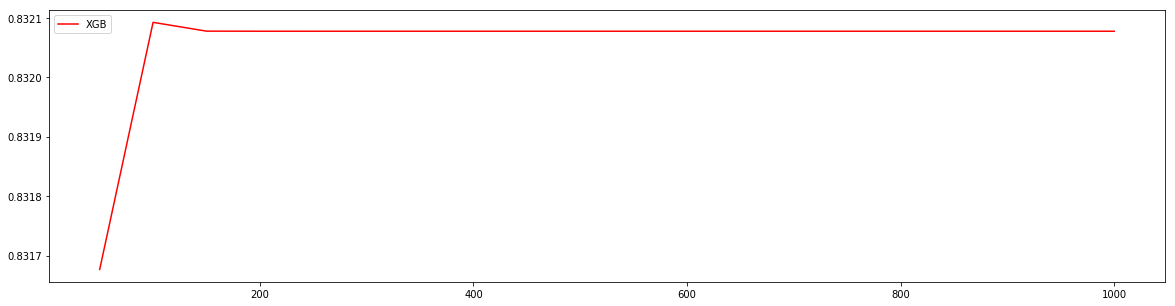

In [23]:
#======【TIME WARNING: 20s】=======#
axisx = range(50,1050,50)
rs = []
var = []ax
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2+cvresult.var())
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517 0.03353715574288529


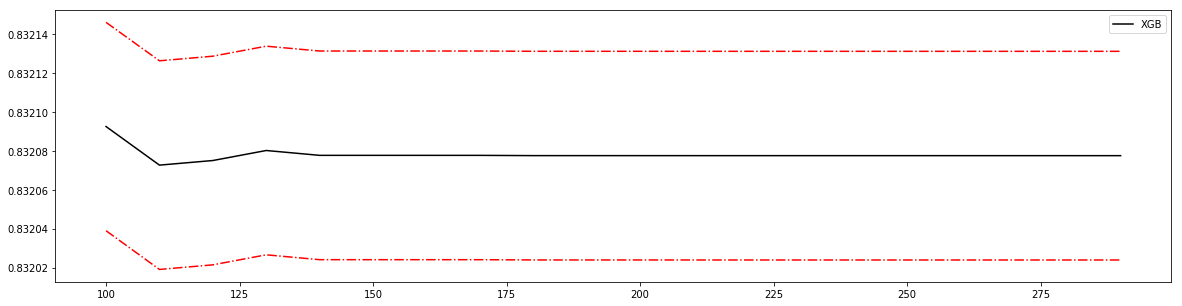

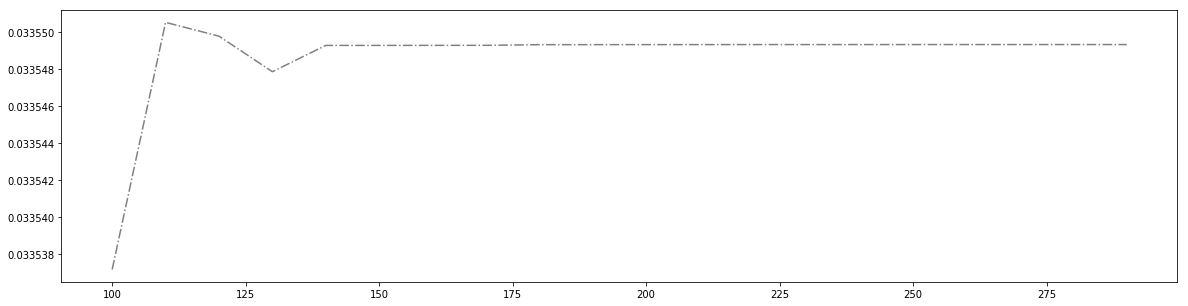

In [24]:
axisx = range(100,300,10)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()
#看看泛化误差的可控部分如何？
plt.figure(figsize=(20,5))
plt.plot(axisx,ge,c="gray",linestyle='-.')
plt.show()

In [25]:
#验证模型效果是否提高了？
time0 = time()
print(XGBR(n_estimators=100,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)

0.9050988954757183
0.12393617630004883


In [26]:
time0 = time()
print(XGBR(n_estimators=660,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)

0.9050526024842831
0.3537757396697998


In [27]:
time0 = time()
print(XGBR(n_estimators=180,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)

0.9050526024842831
0.19688773155212402


梯度提升树：   
从总的数据集里随机抽取样本，得到一个新的数据集，将数据集里判断错的数据返回给原始数据集，原始数据集会增大   
这些被判断错误的数据的权重，然后抽样得到一个新的数据集，如此往复，知道第k次。每一次抽样都是在前一次的基础   
上进行的，精度都比之前提升了一点。

1.0 0.8320775357206376


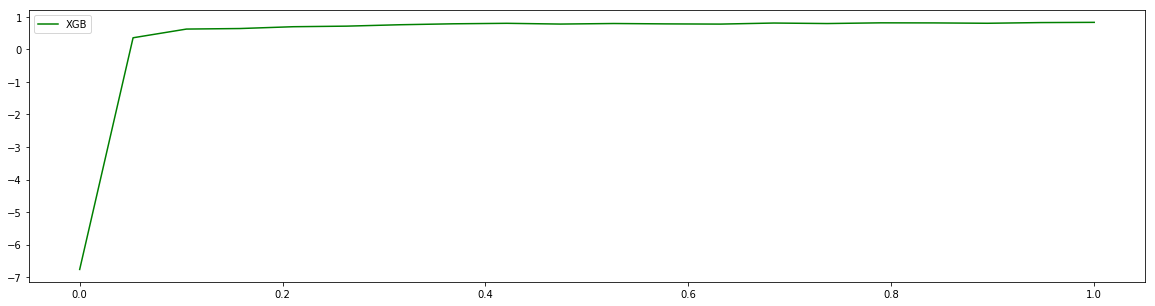

In [28]:
axisx = np.linspace(0,1,20)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=180,subsample=i,random_state=420)
    rs.append(CVS(reg,Xtrain,Ytrain,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

1.0 0.8320775357206376 0.005351385532660411
0.75 0.8173343595502246 0.002674386743068867
1.0 0.8320775357206376 0.005351385532660411 0.033549339542314156


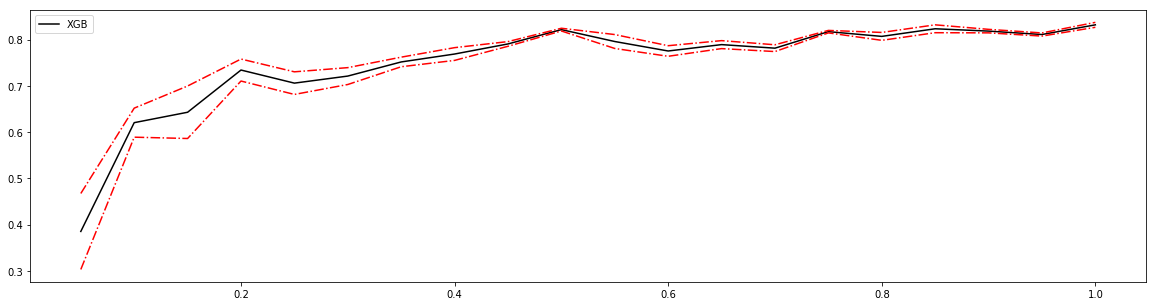

In [29]:
#细化学习曲线
axisx = np.linspace(0.05,1,20)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=180,subsample=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

In [30]:
#继续细化学习曲线
axisx = np.linspace(0.75,1,25)
#不要盲目找寻泛化误差可控部分的最低值，注意观察结果
#看看泛化误差的情况如何
reg = XGBR(n_estimators=180
            ,subsample=0.7708333333333334
            ,random_state=420).fit(Xtrain,Ytrain)

In [31]:
reg.score(Xtest,Ytest)

0.902174931381379

In [32]:
MSE(Ytest,reg.predict(Xtest))
#这样的结果说明了什么？

9.10300268941902

类似于逻辑回归中的梯度下降，XGboost的迭代也是每棵树加上使损失函数最优的下一棵树乘以权重，梯度   
下降中称之为学习率和梯度，eta不能太小也不能太大。同梯度下降。

集成学习的树的个数和eta需要用网格搜索来进行。

In [33]:
#首先我们先来定义一个评分函数，这个评分函数能够帮助我们直接打印Xtrain上的交叉验证结果
def regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2"],show=True):
    score = []
    for i in range(len(scoring)):
        if show:
            print("{}:{:.2f}".format(scoring[i]
                                    ,CVS(reg
                                    ,Xtrain,Ytrain
                                    ,cv=cv,scoring=scoring[i]).mean()))
        score.append(CVS(reg,Xtrain,Ytrain,cv=cv,scoring=scoring[i]).mean())
    return score   # 分数默认的是我们填写的最后一个值
    #运行一下函数来看看效果

In [34]:
regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2","neg_mean_squared_error"])

r2:0.79
neg_mean_squared_error:-14.12


[0.7944643548951424, -14.116785448848711]

In [35]:
#关闭打印功能试试看？
regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2","neg_mean_squared_error"],show=False)  # 这样就不会去打印，只返回

[0.7944643548951424, -14.116785448848711]

In [36]:
#观察一下eta如何影响我们的模型：
from time import time
import datetime
for i in [0,0.2,0.5,1]:
    time0=time()
    reg = XGBR(n_estimators=180,random_state=420,learning_rate=i)
    print("learning_rate = {}".format(i))
    regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2","neg_mean_squared_error"])
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
    print("\t")

learning_rate = 0
r2:-6.76
neg_mean_squared_error:-567.55
00:03:037285
	
learning_rate = 0.2
r2:0.83
neg_mean_squared_error:-12.30
00:04:058058
	
learning_rate = 0.5
r2:0.82
neg_mean_squared_error:-12.48
00:02:237043
	
learning_rate = 1
r2:0.71
neg_mean_squared_error:-20.06
00:01:705196
	


0.1 0.8354667463386021


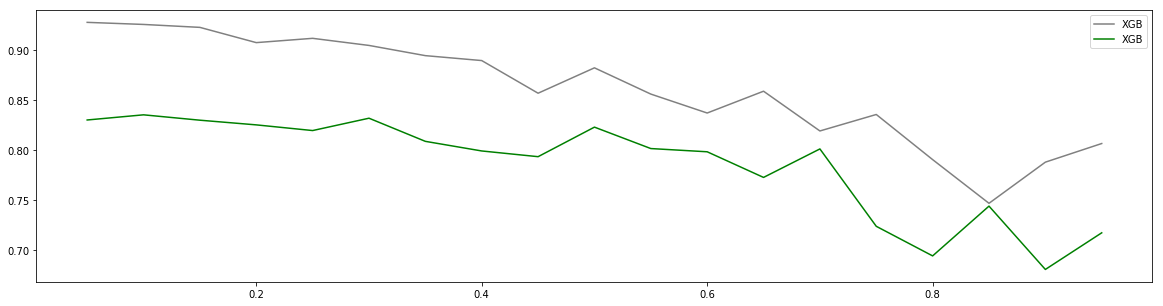

In [37]:
axisx = np.arange(0.05,1,0.05)
rs = []
te = []
for i in axisx:
    reg = XGBR(n_estimators=180,random_state=420,learning_rate=i)
    score = regassess(reg,Xtrain,Ytrain,cv,scoring =["r2","neg_mean_squared_error"],show=False)
    test = reg.fit(Xtrain,Ytrain).score(Xtest,Ytest)
    rs.append(score[0])
    te.append(test)
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,te,c="gray",label="XGB")
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

梯度提升树是XGboost的基础，我们学习了有关的四个参数：n_estimators\eta\silent\subsample.    
这四个参数不是为了提升算法，而是让我们更加的了解梯度提升树的原理。   
梯度提升树由三部分组成：   
1）、一种能衡量最优化算法效果的，能够被最优化的损失函数。   
2）、一个能够实现预测的若评估器。   
3）、一种能够让若评估器集成的手段，包括我们所讲的迭代方法、抽样手段、样本加权等。

XGboost的智慧

1）、选择弱评估器   
在xgboost中是xgb_model,sklean中是booseter   
可以输入gbtree(梯度提升树）,gblinear（线性模型）,dart（抛弃提升树）   
其中gblinear有点像boosting

In [38]:
for booster in ["gbtree","gblinear","dart"]:
    reg = XGBR(n_estimators=180
                ,learning_rate=0.1
                ,random_state=420
                ,booster=booster).fit(Xtrain,Ytrain)
    print(booster)
    print(reg.score(Xtest,Ytest))    #自己找线性数据试试看"gblinear"的效果吧~

gbtree
0.9260984298390122
gblinear
0.6502163867803991
dart
0.9260984373654244


XGboost的目标函数：重要参数objective

损失函数写成了：传统损失函数（RMSE）+模型复杂度

xgb.train(obj(binary:logstic))\xgb.XGBRegressior(objective(reg:linear))\xgb.XGBClassifier(objective(binary:logstic))

reg:logstic   
binary:linear   
binary:hinge   
mutil:softmax

xgb.DMtricx()   # 读取   
param()        # 设置参数   
bst = xgb.train(param)   # 模型训练   
bst.predict()     # 预测

In [39]:
#默认reg:linear
reg = XGBR(n_estimators=180,random_state=420).fit(Xtrain,Ytrain)

In [40]:
reg.score(Xtest,Ytest)

0.9050526024842831

In [41]:
MSE(Ytest,reg.predict(Xtest))

8.835224213421986

In [42]:
#xgb实现法
import xgboost as xgb

In [43]:
#使用类Dmatrix读取数据
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

In [44]:
#非常遗憾无法打开来查看，所以通常都是先读到pandas里面查看之后再放到DMatrix中
dtrain

In [46]:
#写明参数，silent默认为False，通常需要手动将它关闭
param = {'silent':True,'objective':'reg:linear',"eta":0.1}
num_round = 180  # n_estimators,这个是单独写的，而silent和objective是在param中写的，注意区别

In [47]:
####类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train(param, dtrain, num_round)
#接口predict

[11:09:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:09:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [48]:
from sklearn.metrics import r2_score

In [49]:
r2_score(Ytest,bst.predict(dtest))

0.9260984298390122

In [50]:
MSE(Ytest,bst.predict(dtest))

6.87682821415069

从R方和MSE可以看出，都是xgboost库本身的效果更好，所以尽量使用XGboost库本身来调用，不要使用sklearn。

重要参数：gamma

In [ ]:
# 使用网格搜索来查找最佳参数组合lambda和alpha
from sklearn.model_selection import GridSearchCV
param = {"reg_alpha":np.arange(0,5,0.05),"reg_lambda":np.arange(0,2,0.05)}
gscv = GridSearchCV(reg,param_grid = param,scoring = "neg_mean_squared_error",cv=cv)

time0 = time()
gscv.fit(Xtrain,Ytrain)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
gscv.best_score_
gscv.best_params_
preds = gscv.predict(Xtest)

from sklearn.metrics import r2_score,mean_squared_error as MSE
r2_score(Ytest,preds)
MSE(Ytest,preds)

0.8 0.8408699414823027 0.00589139909078231
4.55 0.8270850755911514 0.004605424043983733
0.6000000000000001 0.8398453632476865 0.004660987707966449 0.030310495381231917


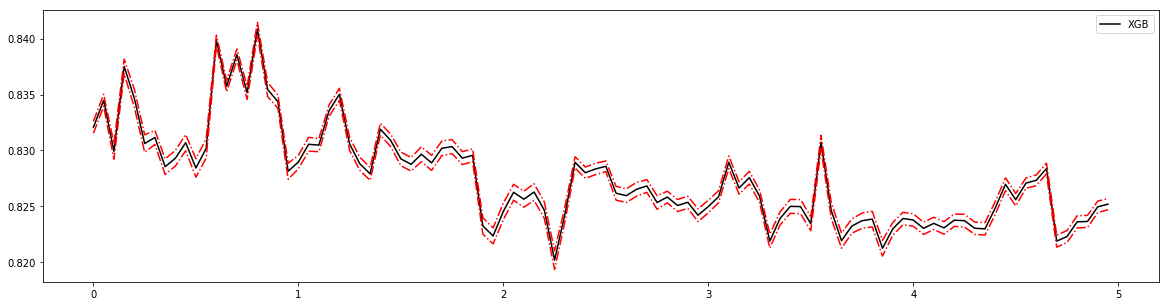

In [51]:
# 让gamma在0~5之间取学习曲线，不推荐使用这种方法
axisx = np.arange(0,5,0.05)
rs = []   # 偏差
var = []   # 方差
ge = []
for i in axisx:
    reg = XGBR(n_estimators=180,random_state=420,gamma=i)
    result = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(result.mean())
    var.append(result.var())
    ge.append((1 - result.mean())**2+result.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.1
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

完全无法看出什么趋势，调参的话效果很难保证，为了调整gamma，我们需要引入新的工具，xgboost.cv

[11:16:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:16:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:16:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in langu

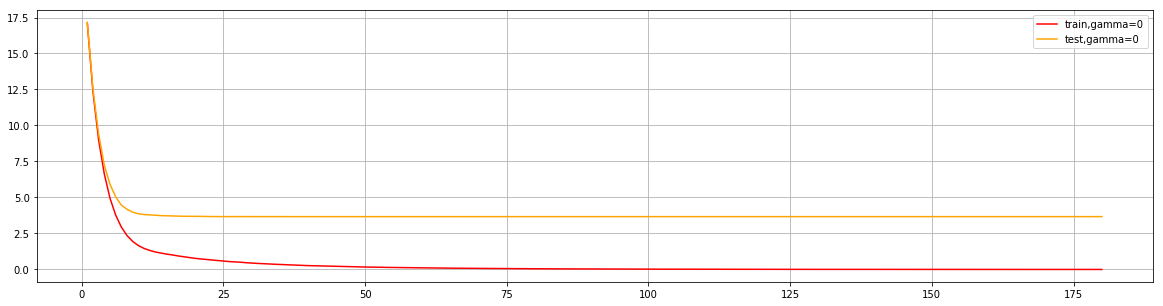

In [52]:
import xgboost as xgb
#为了便捷，使用全数据
dfull = xgb.DMatrix(X,y)
#设定参数
param1 = {'silent':True,'obj':'reg:linear',"gamma":0}
num_round = 180
n_fold=5
#使用类xgb.cv
time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
#看看类xgb.cv生成了什么结果？
cvresult1
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,181),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,181),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.legend()
plt.show()
#xgboost中回归模型的默认模型评估指标是什么？

了解xgboost自带的模型评估指标：   
rmse:回归用，调整后的MSE   
mae:回归用，绝对平均误差   
logloss：二分类用哪个，对数损失   
mlogloss：多分类，对数损失   
error：分类用，分类误差，等于1-准确率   
auc：分类，AUC面积

[11:20:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:20:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:20:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in langu

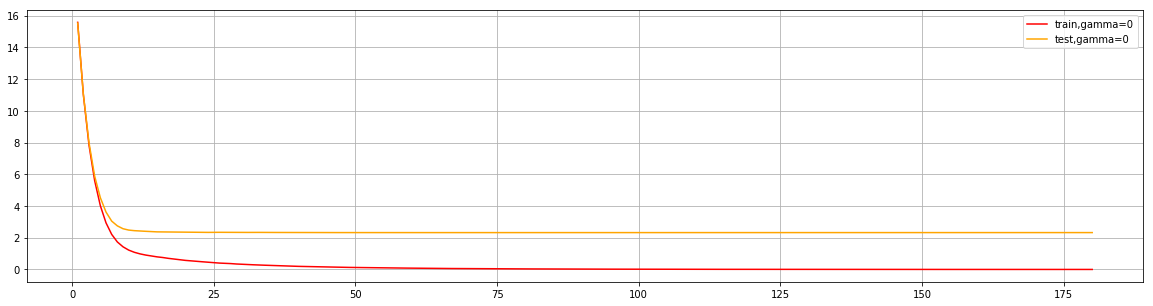

In [54]:
param1 = {'silent':False,'obj':'reg:linear',"gamma":0,"eval_metric":"mae"}
cvresult1 = xgb.cv(param1, dfull, num_round,n_fold)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,181),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,181),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.legend()
plt.show()
#从这个图中，我们可以看出什么？
#怎样从图中观察模型的泛化能力？
#从这个图的角度来说，模型的调参目标是什么？

[11:20:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:20:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:20:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in langu

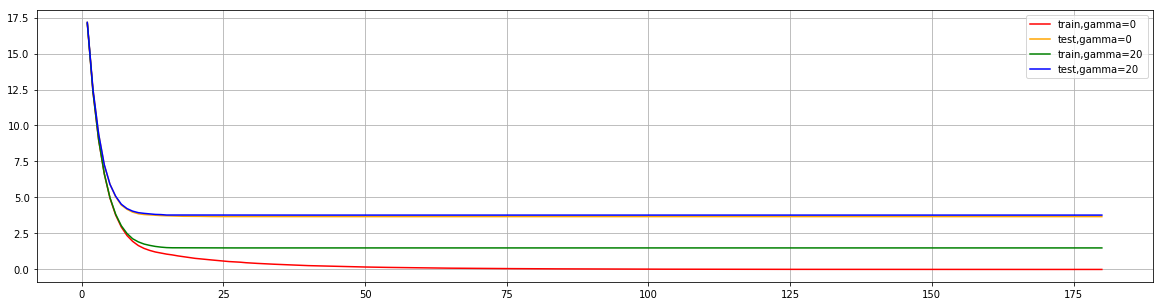

In [55]:
# 调整gamma，观察变化
param1 = {'silent':True,'obj':'reg:linear',"gamma":0}
param2 = {'silent':True,'obj':'reg:linear',"gamma":20}
num_round = 180
n_fold=5
time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
time0 = time()
cvresult2 = xgb.cv(param2, dfull, num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,181),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,181),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.plot(range(1,181),cvresult2.iloc[:,0],c="green",label="train,gamma=20")
plt.plot(range(1,181),cvresult2.iloc[:,2],c="blue",label="test,gamma=20")
plt.legend()
plt.show()
#从这里，你看出gamma是如何控制过拟合了吗？

尝试一个分类的例子

[11:21:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:21:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:21:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters a

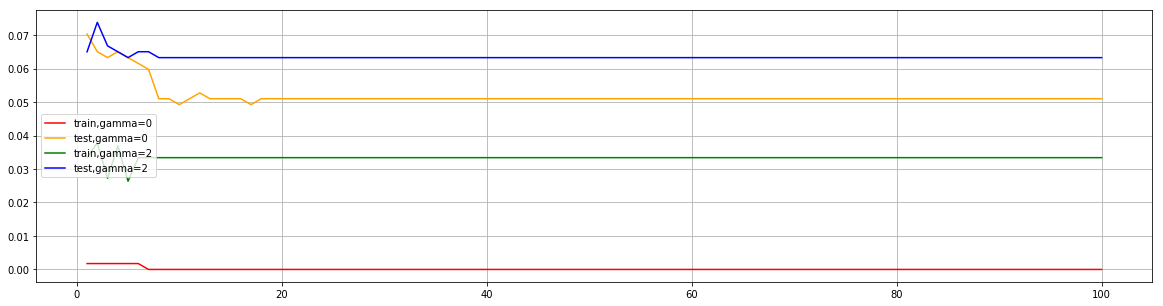

In [56]:
from sklearn.datasets import load_breast_cancer
data2 = load_breast_cancer()
x2 = data2.data
y2 = data2.target
dfull2 = xgb.DMatrix(x2,y2)
param1 = {'silent':True,'obj':'binary:logistic',"gamma":0,"nfold":5}
param2 = {'silent':True,'obj':'binary:logistic',"gamma":2,"nfold":5}
num_round = 100
time0 = time()
cvresult1 = xgb.cv(param1, dfull2, num_round,metrics=("error"))
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
time0 = time()
cvresult2 = xgb.cv(param2, dfull2, num_round,metrics=("error"))
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,101),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,101),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.plot(range(1,101),cvresult2.iloc[:,0],c="green",label="train,gamma=2")
plt.plot(range(1,101),cvresult2.iloc[:,2],c="blue",label="test,gamma=2")
plt.legend()
plt.show()

总结：   
有了xgboost.cv这个工具，我们的参数调整变得容易得多了，让我们直接看到参数如何直接影响模型的泛华能力。   
下面讲解xgboost.cv的参数调整了。

XGboost的应用部分

作为树模型，减轻过拟合的方式主要靠剪枝来降低模型复杂度，以求降低方差。有复杂度控制gamma，正则化参数alpha和lambda，控制   
迭代速度eta，随机又放回抽样subsample。   
除此，还有max_depth,和alpha效果一样。   
当我们获得一个数据集后，我们先使用网格搜索找出比较合适的n_estimators和eta组合，然后使用gamma或max_depth观察   
模型处于什么样的状态，（过拟合还是欠拟合，处于方差-偏差左边还是右边），最后在就那些剪枝调参，以调出泛化能力很强的参数。

[11:22:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:22:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:22:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters a

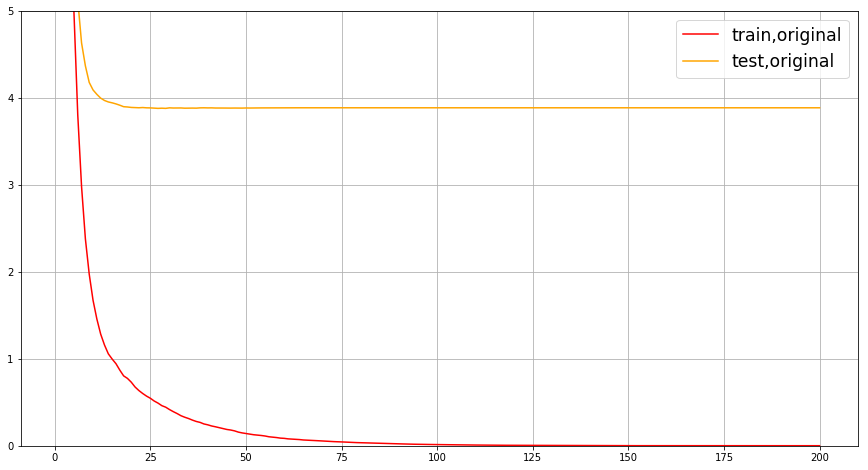

In [57]:
dfull = xgb.DMatrix(X,y)
param1 = {'silent':True #并非默认
            ,'obj':'reg:linear' #并非默认
            ,"subsample":1
            ,"max_depth":6
            ,"eta":0.3
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0
            ,"colsample_bytree":1
            ,"colsample_bylevel":1
            ,"colsample_bynode":1
            ,"nfold":5}
num_round = 200

time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

fig,ax = plt.subplots(1,figsize=(15,8))
ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1,201),cvresult1.iloc[:,0],c="red",label="train,original")
ax.plot(range(1,201),cvresult1.iloc[:,2],c="orange",label="test,original")
ax.legend(fontsize="xx-large")  # 调整字号大小
plt.show()

[11:23:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:23:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:23:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters a

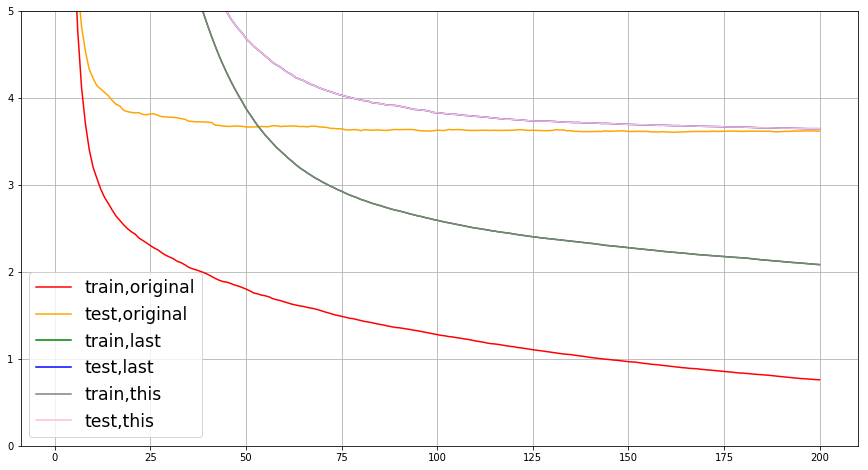

In [58]:
param1 = {'silent':True #并非默认
            ,'obj':'reg:linear' #并非默认
            ,"subsample":1
            ,"max_depth":2
            ,"eta":0.3
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0
            ,"colsample_bytree":1
            ,"colsample_bylevel":1
            ,"colsample_bynode":1
            ,"nfold":5}
num_round = 200
time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
fig,ax = plt.subplots(1,figsize=(15,8))
ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1,201),cvresult1.iloc[:,0],c="red",label="train,original")
ax.plot(range(1,201),cvresult1.iloc[:,2],c="orange",label="test,original")
param2 = {'silent':True
            ,'obj':'reg:linear'
            ,"max_depth":2
            ,"eta":0.05
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0
            ,"nfold":5}
param3 = {'silent':True
            ,'obj':'reg:linear'
            ,"max_depth":2
            ,"eta":0.05
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0
            ,"nfold":5}
time0 = time()
cvresult2 = xgb.cv(param2, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
time0 = time()
cvresult3 = xgb.cv(param3, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
ax.plot(range(1,201),cvresult2.iloc[:,0],c="green",label="train,last")
ax.plot(range(1,201),cvresult2.iloc[:,2],c="blue",label="test,last")
ax.plot(range(1,201),cvresult3.iloc[:,0],c="gray",label="train,this")
ax.plot(range(1,201),cvresult3.iloc[:,2],c="pink",label="test,this")
ax.legend(fontsize="xx-large")
plt.show()

[11:23:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:23:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:23:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { nfold, obj, silent } might not be used.

  This may not be accurate due to some parameters a

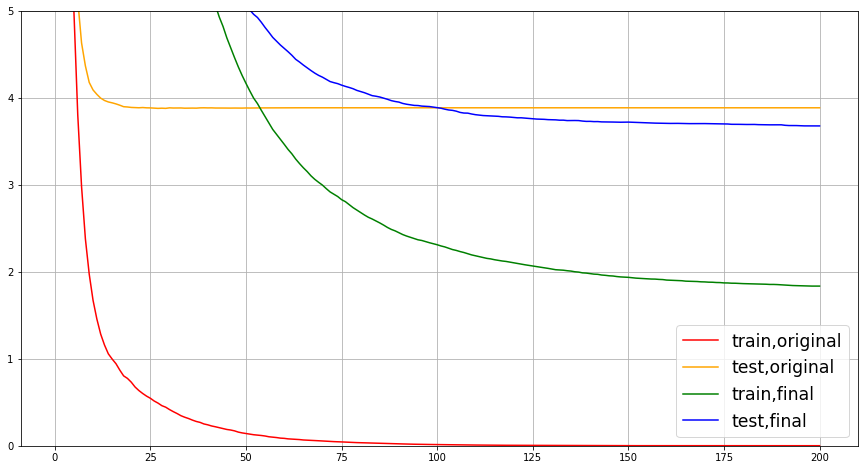

In [59]:
#默认设置
param1 = {'silent':True
            ,'obj':'reg:linear'
            ,"subsample":1
            ,"max_depth":6
            ,"eta":0.3
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0
            ,"colsample_bytree":1
            ,"colsample_bylevel":1
            ,"colsample_bynode":1
            ,"nfold":5}
num_round = 200
time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
fig,ax = plt.subplots(1,figsize=(15,8))
ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1,201),cvresult1.iloc[:,0],c="red",label="train,original")
ax.plot(range(1,201),cvresult1.iloc[:,2],c="orange",label="test,original")
#调参结果1
param2 = {'silent':True
            ,'obj':'reg:linear'
            ,"subsample":1
            ,"eta":0.05
            ,"gamma":20
            ,"lambda":3.5
            ,"alpha":0.2
            ,"max_depth":4
            ,"colsample_bytree":0.4
            ,"colsample_bylevel":0.6
            ,"colsample_bynode":1
            ,"nfold":5}
#调参结果2
param3 = {'silent':True
            ,'obj':'reg:linear'
            ,"max_depth":2
            ,"eta":0.05
            ,"gamma":0
            ,"lambda":1
            ,"alpha":0
            ,"colsample_bytree":1
            ,"colsample_bylevel":0.4
            ,"colsample_bynode":1
            ,"nfold":5}
time0 = time()
cvresult2 = xgb.cv(param2, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
ax.plot(range(1,201),cvresult2.iloc[:,0],c="green",label="train,final")
ax.plot(range(1,201),cvresult2.iloc[:,2],c="blue",label="test,final")
ax.legend(fontsize="xx-large")
plt.show()

所以一般的调参顺序是，先用网格搜索调整n_estimators和eta，然后调整gamma或者max_depth，接着调整纵向抽样，最后正则化参数。

In [60]:
import pickle
dtrain = xgb.DMatrix(Xtrain,Ytrain)
#设定参数，对模型进行训练
param = {'silent':True
            ,'obj':'reg:linear'
            ,"subsample":1
            ,"eta":0.05
            ,"gamma":20
            ,"lambda":3.5
            ,"alpha":0.2
            ,"max_depth":4
            ,"colsample_bytree":0.4
            ,"colsample_bylevel":0.6
            ,"colsample_bynode":1}
num_round = 180
bst = xgb.train(param, dtrain, num_round)

[11:23:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { obj, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [61]:
#保存模型
pickle.dump(bst, open("xgboostonboston.dat","wb"))
# 注意，open中我们往往使用w或者r作为读取的模式，但其实w与r只能用于文本文件-txt，当我们希望导入的不是文本文件，而
# 是模型本身的时候，我们使用"wb"和"rb"作为读取的模式。其中wb表示以二进制写入，rb表示以二进制读入
# 使用呢open保存的这个文件中是一个可以读取或者调用的模型
# 看看模型被保存到了哪里？

In [62]:
import sys
sys.path

['D:\\anaconda_running',
 'C:\\ProgramData\\Anaconda3\\python37.zip',
 'C:\\ProgramData\\Anaconda3\\DLLs',
 'C:\\ProgramData\\Anaconda3\\lib',
 'C:\\ProgramData\\Anaconda3',
 '',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\YUTIAN\\.ipython']

In [1]:
#重新打开jupyter lab
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pickle
import xgboost as xgb
data = load_boston()
X = data.data
y = data.target
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
#注意，如果我们保存的模型是xgboost库中建立的模型，则导入的数据类型也必须是xgboost库中的数据类型
dtest = xgb.DMatrix(Xtest,Ytest)

In [3]:
#导入模型
loaded_model = pickle.load(open("xgboostonboston.dat", "rb"))
print("Loaded model from: xgboostonboston.dat")

Loaded model from: xgboostonboston.dat


In [6]:
#做预测
ypreds = loaded_model.predict(dtest)

In [7]:
ypreds

array([ 9.278189 , 22.73411  , 29.49379  , 12.983151 ,  9.501983 ,
       20.643223 , 15.9423685, 15.831041 , 15.698413 , 15.967682 ,
       21.101307 , 35.83475  , 20.486403 , 29.231373 , 20.785269 ,
       12.0639305, 17.63428  , 26.05238  , 25.247683 , 23.5034   ,
       18.007511 , 16.483337 , 25.402018 , 22.421213 , 20.117733 ,
       16.29774  , 21.58729  , 25.936457 , 23.091265 , 16.585096 ,
       35.397484 , 20.128452 , 20.370457 , 23.711695 , 23.2132   ,
       24.522053 , 16.185253 , 23.857044 , 18.047995 , 34.886375 ,
       17.50002  , 21.3877   , 33.375374 , 18.835121 , 15.2021055,
       28.557238 , 42.05484  , 16.839178 , 10.032376 , 37.126007 ,
       26.214668 , 21.136719 , 20.564241 , 47.079376 , 27.928053 ,
       25.919254 , 18.91586  , 20.737247 , 17.17016  , 18.296001 ,
       15.074966 , 23.753801 , 19.82896  , 31.379152 , 29.385721 ,
       20.15055  , 20.94952  , 17.336159 , 22.490997 , 16.978096 ,
       28.754507 , 40.5415   , 30.079725 , 22.954508 , 20.1310

In [5]:
from sklearn.metrics import mean_squared_error as MSE, r2_score

In [8]:
MSE(Ytest,ypreds)

9.17837612641537

In [10]:
r2_score(Ytest,ypreds)

0.9013649336369249

Joblib是SciPy生态系统中的一部分，它为Python提供保存和调用管道和对象的功能，处理NumPy结构的数据尤其高
效，对于很大的数据集和巨大的模型非常有用。Joblib与pickle API非常相似

In [ ]:
bst = xgb.train(param, dtrain, num_round)

import joblib

#同样可以看看模型被保存到了哪里
joblib.dump(bst,"xgboost-boston.dat")   # 不许用open，直接写上文件名就行了，默认本地址

loaded_model = joblib.load("xgboost-boston.dat")

ypreds = loaded_model.predict(dtest)

MSE(Ytest, ypreds)

r2_score(Ytest,ypreds)

#使用sklearn中的模型
from xgboost import XGBRegressor as XGBR
bst = XGBR(n_estimators=200
            ,eta=0.05,gamma=20
            ,reg_lambda=3.5
            ,reg_alpha=0.2
            ,max_depth=4
            ,colsample_bytree=0.4
            ,colsample_bylevel=0.6).fit(Xtrain,Ytrain)
joblib.dump(bst,"xgboost-boston.dat")
loaded_model = joblib.load("xgboost-boston.dat")

#则这里可以直接导入Xtest
ypreds = loaded_model.predict(Xtest)

MSE(Ytest, ypreds)

XGB中样本不均衡问题

In [63]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier as XGBC
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import confusion_matrix as cm, recall_score as recall, roc_auc_score as auc

In [64]:
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

In [65]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=0.3,random_state=420)

In [66]:
(y == 1).sum() / y.shape[0]

0.09090909090909091

In [67]:
#在sklearn下建模#
clf = XGBC().fit(Xtrain,Ytrain)
ypred = clf.predict(Xtest)

In [68]:
clf.score(Xtest,Ytest)   # 分类的默认模型评估指标是---准确率

0.9272727272727272

In [69]:
ypred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [70]:
cm(Ytest,ypred,labels=[1,0])

array([[  9,   4],
       [  8, 144]], dtype=int64)

In [71]:
recall(Ytest,ypred)

0.6923076923076923

In [72]:
auc(Ytest,clf.predict_proba(Xtest)[:,1])

0.9701417004048585

In [73]:
#负/正样本比例
clf_ = XGBC(scale_pos_weight=10).fit(Xtrain,Ytrain)

ypred_ = clf_.predict(Xtest)

clf_.score(Xtest,Ytest)

0.9333333333333333

In [74]:
cm(Ytest,ypred_,labels=[1,0])

array([[ 10,   3],
       [  8, 144]], dtype=int64)

In [75]:
recall(Ytest,ypred_)

0.7692307692307693

In [76]:
auc(Ytest,clf_.predict_proba(Xtest)[:,1])

0.9696356275303644

In [77]:
#随着样本权重逐渐增加，模型的recall,auc和准确率如何变化？
for i in [1,5,10,20,30]:
    clf_ = XGBC(scale_pos_weight=i).fit(Xtrain,Ytrain)
    ypred_ = clf_.predict(Xtest)
    print(i)
    print("\tAccuracy:{}".format(clf_.score(Xtest,Ytest)))
    print("\tRecall:{}".format(recall(Ytest,ypred_)))
    print("\tAUC:{}".format(auc(Ytest,clf_.predict_proba(Xtest)[:,1])))

1
	Accuracy:0.9272727272727272
	Recall:0.6923076923076923
	AUC:0.9701417004048585
5
	Accuracy:0.9393939393939394
	Recall:0.8461538461538461
	AUC:0.9660931174089069
10
	Accuracy:0.9333333333333333
	Recall:0.7692307692307693
	AUC:0.9696356275303644
20
	Accuracy:0.9333333333333333
	Recall:0.7692307692307693
	AUC:0.9686234817813765
30
	Accuracy:0.9393939393939394
	Recall:0.8461538461538461
	AUC:0.9701417004048583


In [78]:
#负/正样本比例
clf_ = XGBC(scale_pos_weight=20).fit(Xtrain,Ytrain)

ypred_ = clf_.predict(Xtest)

clf_.score(Xtest,Ytest)

0.9333333333333333

In [79]:
cm(Ytest,ypred_,labels=[1,0])

array([[ 10,   3],
       [  8, 144]], dtype=int64)

In [80]:
recall(Ytest,ypred_)

0.7692307692307693

In [81]:
auc(Ytest,clf_.predict_proba(Xtest)[:,1])

0.9686234817813765

使用xgboost的情况

In [82]:
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

In [83]:
#看看xgboost库自带的predict接口
param= {'silent':True,'objective':'binary:logistic',"eta":0.1,"scale_pos_weight":1}
num_round = 100

In [84]:
bst = xgb.train(param, dtrain, num_round)

[11:28:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [85]:
preds = bst.predict(dtest)
#看看preds返回了什么？
preds

array([0.00110357, 0.00761518, 0.00110357, 0.00110357, 0.93531454,
       0.00466839, 0.00110357, 0.00110357, 0.00110357, 0.00110357,
       0.00110357, 0.00410493, 0.00454478, 0.00571528, 0.00751026,
       0.00110357, 0.00110357, 0.00110357, 0.00110357, 0.00110357,
       0.00110357, 0.00110357, 0.00110357, 0.00110357, 0.00110357,
       0.00712637, 0.00110357, 0.00110357, 0.00110357, 0.00110357,
       0.00110357, 0.00110357, 0.00110357, 0.00793251, 0.00466839,
       0.00110357, 0.00339395, 0.00657186, 0.00110357, 0.00457053,
       0.00571528, 0.0026763 , 0.00110357, 0.00110357, 0.00110357,
       0.00884932, 0.00712637, 0.00110357, 0.00712637, 0.00466839,
       0.00110357, 0.00110357, 0.00712637, 0.00110357, 0.00110357,
       0.00110357, 0.00110357, 0.63748044, 0.00110357, 0.00793251,
       0.00110357, 0.00451971, 0.00644181, 0.00110357, 0.00110357,
       0.00110357, 0.00110357, 0.00751026, 0.00712637, 0.00110357,
       0.00866458, 0.00110357, 0.00110357, 0.00110357, 0.91610

In [86]:
#自己设定阈值
ypred = preds.copy()

In [87]:
ypred[preds > 0.5] = 1
ypred[ypred != 1] = 0

In [88]:
#写明参数
scale_pos_weight = [1,5,10]
names = ["negative vs positive: 1"
        ,"negative vs positive: 5"
        ,"negative vs positive: 10"]

In [89]:
#导入模型评估指标
from sklearn.metrics import accuracy_score as accuracy, recall_score as recall,roc_auc_score as auc

In [90]:
for name,i in zip(names,scale_pos_weight):
    param= {'silent':True,'objective':'binary:logistic'
           ,"eta":0.1,"scale_pos_weight":i}
    clf = xgb.train(param, dtrain, num_round)
    preds = clf.predict(dtest)
    ypred = preds.copy()
    ypred[preds > 0.5] = 1
    ypred[ypred != 1] = 0
    print(name)
    print("\tAccuracy:{}".format(accuracy(Ytest,ypred)))
    print("\tRecall:{}".format(recall(Ytest,ypred)))
    print("\tAUC:{}".format(auc(Ytest,preds)))

[11:28:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


negative vs positive: 1
	Accuracy:0.9272727272727272
	Recall:0.6923076923076923
	AUC:0.9741902834008097
[11:28:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


negative vs positive: 5
	Accuracy:0.9393939393939394
	Recall:0.8461538461538461
	AUC:0.9635627530364372
[11:28:45] WARNING: C:\U

In [91]:
#当然我们也可以尝试不同的阈值
for name,i in zip(names,scale_pos_weight):
    for thres in [0.3,0.5,0.7,0.9]:
        param= {'silent':True,'objective':'binary:logistic'
                ,"eta":0.1,"scale_pos_weight":i}
        clf = xgb.train(param, dtrain, num_round)
        preds = clf.predict(dtest)
        ypred = preds.copy()
        ypred[preds > thres] = 1
        ypred[ypred != 1] = 0
        print("{},thresholds:{}".format(name,thres))
        print("\tAccuracy:{}".format(accuracy(Ytest,ypred)))
        print("\tRecall:{}".format(recall(Ytest,ypred)))
        print("\tAUC:{}".format(auc(Ytest,preds)))

[11:29:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


negative vs positive: 1,thresholds:0.3
	Accuracy:0.9393939393939394
	Recall:0.8461538461538461
	AUC:0.9741902834008097
[11:29:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


negative vs positive: 1,thresholds:0.5
	Accuracy:0.9272727272727272
	Recall:0.6923076923076923
	AUC:0.97419028340